# Introduction to Python Session 7

Our last session focused on closing out the rest of Chapter 3. We examined centrality measures and took examine how an API is used to fetch data from an online data source. This session will focus on chapter 4. Chapter 4 has been the motivation behind these sessions. Our goal has always been to develop some method of clustering within graph networks. 

We first introduce the idea of a subgraph. The subgraph is defined as a subset of nodes and linked edges from some network. A subgraph can be constructed from any group of nodes. 

Component subgraphs are simply known as components. They are a type of subgraph. They are defined as portions of the network that are disconnected from each other. The text book uses Romeo and Juliet as an example. Their respective families would be considered components since they are not connected with each other with the exception of Romeo's connection to Juliet. 

It should be noted that in real world data, components could come about due to sampling errors in the data collection or ther simply exists no ties between components outside of the sampling scope. 

We will be using a data source not found in the book. We actually need to read in CSV files. One csv file is going to contain nodes and the other csv will contain edge definitions. This data set is called the Society of Friends. The data lists the names and relationships among 17th century quakers. 

Tutorial: https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

In [1]:
import pandas as pd
import csv
from operator import itemgetter #To manipulate dictionary objects
import networkx as nx
from networkx.algorithms import community #community detection
import matplotlib.pyplot as plt

In [2]:
q_nodelist=pd.read_csv('quakers_nodelist.csv')

q_nodelist.head()

,Name,Historical Significance,Gender,Birthdate,Deathdate,ID
0,Joseph Wyeth,religious writer,male,1663,1731,10013191
1,Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149
2,James Logan,colonial official and scholar,male,1674,1751,10007567
3,Dorcas Erbery,Quaker preacher,female,1656,1659,10003983
4,Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152


In the CSV shown above, we are given the name of the node and certain attributes associated with the node. IN our example, we see that each node represents a person and each person has attributes such as Gender and Birth. 

For our purposes, we should start thinking about how to query data to define a node-attribute tab. Instead of names, we could have unique visitor ID's where their attributes could be some of their third party demographic features or first party behaviors. 

We could also consider a node table to be at story level granularity such that each row pertains to a specific URL or slug and the attributes could be pageviews, topic classification etc. 

In [3]:
q_nodelist=pd.read_csv('quakers_edgelist.csv')

q_nodelist.head()

,Source,Target
0,George Keith,Robert Barclay
1,George Keith,Benjamin Furly
2,George Keith,Anne Conway Viscountess Conway and Killultagh
3,George Keith,Franciscus Mercurius van Helmont
4,George Keith,William Penn


The table above demonstrates what edge definitions look like in a CSV file. We have two columns. The first column contains the source node name and the second column contains the target node name. 

For our purposes, we can think about how we would want to define an edge table. One example could be finding a user who read a story by their URL and connecting it to another user who read the same story. 

If nodes are stories, then edges, then we can think of edges (connections) as being users who read the same story. For example if Story A has the same reader as story B, then connect story A and story B with an edge.

The following code shows how to read in a node list csv and edge list csv. 

In [4]:
with open('quakers_nodelist.csv', 'r') as nodecsv: # Open the file
    
    nodereader = csv.reader(nodecsv) # Read the csv
    
    # Retrieve the data (using Python list comprhension and list slicing to remove the header row)
    nodes = [n for n in nodereader][1:]

node_names = [n[0] for n in nodes] # Get a list of only the node names

with open('quakers_edgelist.csv', 'r') as edgecsv: # Open the file
    
    edgereader = csv.reader(edgecsv) # Read the csv
    
    edges = [tuple(e) for e in edgereader][1:] # Retrieve the data

Take a moment to look at the new format for the nodes. We have what is called a list of lists. Each sublist has the node name along with the node attributes. Ask yourself, is the following object mutable or immutable? 

In [5]:
nodes

[['Joseph Wyeth', 'religious writer', 'male', '1663', '1731', '10013191'],
 ['Alexander Skene of Newtyle',
  'local politician and author',
  'male',
  '1621',
  '1694',
  '10011149'],
 ['James Logan',
  'colonial official and scholar',
  'male',
  '1674',
  '1751',
  '10007567'],
 ['Dorcas Erbery', 'Quaker preacher', 'female', '1656', '1659', '10003983'],
 ['Lilias Skene',
  'Quaker preacher and poet',
  'male',
  '1626',
  '1697',
  '10011152'],
 ['William Mucklow', 'religious writer', 'male', '1630', '1713', '10008595'],
 ['Thomas Salthouse',
  'Quaker preacher and writer',
  'male',
  '1630',
  '1691',
  '10010643'],
 ['William Dewsbury', 'Quaker activist', 'male', '1621', '1688', '10003478'],
 ['John Audland', 'Quaker preacher', 'male', '1630', '1664', '10000411'],
 ['Richard Claridge',
  'Quaker minister and schoolmaster',
  'male',
  '1649',
  '1723',
  '10002469'],
 ['William Bradford', 'printer', 'male', '1663', '1752', '10001445'],
 ['Fettiplace Bellers',
  'philosophical wri

Lets also look at what we did with the edges data. This is also a list of lists. Each sublist has two elements ordered from origin node to target node. 

In [5]:
edges

[('George Keith', 'Robert Barclay'),
 ('George Keith', 'Benjamin Furly'),
 ('George Keith', 'Anne Conway Viscountess Conway and Killultagh'),
 ('George Keith', 'Franciscus Mercurius van Helmont'),
 ('George Keith', 'William Penn'),
 ('George Keith', 'George Fox'),
 ('George Keith', 'George Whitehead'),
 ('George Keith', 'William Bradford'),
 ('James Parnel', 'Benjamin Furly'),
 ('James Parnel', 'Stephen Crisp'),
 ('Peter Collinson', 'John Bartram'),
 ('Peter Collinson', 'James Logan'),
 ('Joseph Wyeth', 'Thomas Ellwood'),
 ('Alexander Skene of Newtyle', 'Lilias Skene'),
 ('Dorcas Erbery', 'James Nayler'),
 ('William Mucklow', 'George Fox'),
 ('Franciscus Mercurius van Helmont', 'Benjamin Furly'),
 ('William Dewsbury', 'Edward Burrough'),
 ('William Dewsbury', 'George Fox'),
 ('William Dewsbury', 'John Crook'),
 ('John Audland', 'John Camm'),
 ('John Audland', 'Francis Howgill'),
 ('John Audland', 'Edward Pyott'),
 ('John Audland', 'Charles Marshall'),
 ('John Audland', 'George Fox'),
 

Q: Why don't we put everything in a single table? 

A: Putting node attributes and edges into a single table is an example of poor database management. We would no longer have a case where every row in the node-attribute table would be a unique node since connections could be one to many. We would end up having duplication of attributes thus increasing the dimension of the data. 

In [5]:
G = nx.Graph()

G.add_nodes_from(node_names)

G.add_edges_from(edges)

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 174
Average degree:   2.9244


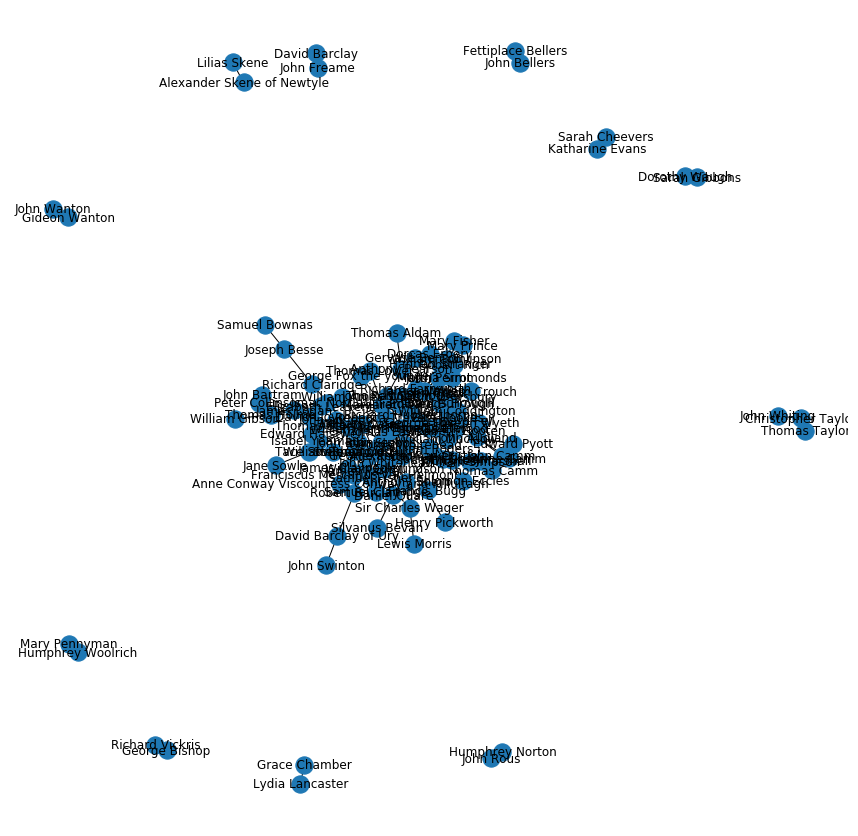

In [6]:
print(nx.info(G))

plt.figure(figsize=(15,15))

sp = nx.spring_layout(G)

plt.axis("off")

nx.draw_networkx(G, pos = sp, with_labels = True)

plt.show()

We can use print(nx.info(G)) to print out some descriptive information regarding this network. It is visually difficult to see but we know there are 119 nodes, 174 edges, and an average degree of 2.9. The next step in the tutorial is to add attributes to our graph. We are given the following code:

In [8]:
#Creates empty dictionaries that will be populated with a loop in the next chunk 
hist_sig_dict = {}

gender_dict = {}

birth_dict = {}

death_dict = {}

id_dict = {}

The above code is going to assign empty dictionary shells for each attribute. We are going to populate each shell using a loop and save each node attribute in its own dictionary.  

In [9]:
for node in nodes: # Loop through the list, one row at a time
    
    hist_sig_dict[node[0]] = node[1]
    
    gender_dict[node[0]] = node[2]
    
    birth_dict[node[0]] = node[3]
    
    death_dict[node[0]] = node[4]
    
    id_dict[node[0]] = node[5]

This code loops through the node list shown earlier and grabs the first element (index 0) from each sublist (node name). We then grab each subsequent value in the corresponding subsequent index positons. Recall that we converted the node-attribute table to a list of lists as follows: 

[[list 1], [list 2], ... [list n]] 

Each sublist pertains to a unique node. 

"for node in nodes:" means start at [list 1], do some task, then move on to [list 2], do some task...etc. 

What is the task we want to do at each iteration?

"hist_sig_dict[node[0]] = node[1]" means that for the specific node in the sublist, grab the element at the specified index. In this case index 1 since that is where the historical sig value is. 

Here is an example of a sublist. The first element in index zero is the name 'Joseph Wyeth' 
Index 1 contains historical sig
Index 2 contains gender
Index 3 contains birth year 
Index 4 contains death year 
Index 5 contains unique node ID 

['Joseph Wyeth', 'religious writer', 'male', '1663', '1731', '10013191']

To summarize, iterate through each sublist and create a dictionary of node attributes for each node then repeat for the following node. 

In [10]:
nx.set_node_attributes(G, hist_sig_dict, 'historical_significance')

nx.set_node_attributes(G, gender_dict, 'gender')

nx.set_node_attributes(G, birth_dict, 'birth_year')

nx.set_node_attributes(G, death_dict, 'death_year')

nx.set_node_attributes(G, id_dict, 'sdfb_id')

We are adding attributes to our nodes such as historical significance, gender, birth year, death year, and some unqie identification to each node. By the way, the node attributes are given to us in the nodelist csv file in terms of columns. 

## Exploration on Network 

Lets apply some things we already know to understand the structure of our network. 

In [11]:
density = nx.density(G)

print("Network density:", density)

Network density: 0.02478279447372169


The low graph density suggests that we have several nodes that are not connected to each other by an edge. We can check to see if our Graph is indeed connected. If it is, we will return True using is_connected(). If this returns False, then our graph is not connected and we are unable to compute a graph diameter (the shortets path between a pair of nodes) 

In [12]:
# If your Graph has more than one component, this will return False:
print(nx.is_connected(G))

False


We verified that we have a non-connected network. Lets also get an idea of the distribution of degrees by nodes. In otherwords, what are the nodes with the highest number of connections. 

In order to do this, we are going to save a dictionary of node name to degree. We are then going to save that degree count as an additional attribute for each node. Finall, we sort the dictionary of nodes by largest degree count to smallest. Lets print out the top 20 nodes by degree count. 

Note: Sorting a dictionary object by value is actually not an easy thing. Hence we use the itemgetter package to easily bypass all of these extra conversions needed to sort dictionary objects. 
https://thomas-cokelaer.info/blog/2017/12/how-to-sort-a-dictionary-by-values-in-python/

In [29]:
degree_dict = dict(G.degree(G.nodes())) #Automatically create an object that stores node and degree count

nx.set_node_attributes(G, degree_dict, 'degree') #Append degree count as an attribute for node

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True) #Sort by degree count from largest to smallest 

print("Top 20 nodes by degree:") #print message 

for d in sorted_degree[:20]: #iterate over each dictionary element and print 
    
    print(d)

Top 20 nodes by degree:
('George Fox', 22)
('William Penn', 18)
('James Nayler', 16)
('George Whitehead', 13)
('Margaret Fell', 13)
('Benjamin Furly', 10)
('Edward Burrough', 9)
('George Keith', 8)
('Thomas Ellwood', 8)
('Francis Howgill', 7)
('John Perrot', 7)
('John Audland', 6)
('Richard Farnworth', 6)
('Alexander Parker', 6)
('John Story', 6)
('John Stubbs', 5)
('Thomas Curtis', 5)
('John Wilkinson', 5)
('William Caton', 5)
('Anthony Pearson', 5)


Goerge Fox has the highest degree. Lets examine some of the centrality measures associated with this network. From previous lessons, we examined how to print out the centrailty measures for all nodes however that is going to be too much output. Instead we are going to do something similar to what we did for degree by node counts. 

Lets compute the betweeness centraility and eigenvector centraility. We are going to save the resulting dictionary objects. (The output for things such as betweenness_centrality always return a dictionary object). We are then going to append the resulting measures as attributes for each node. 

I know we did not cover betweeness centrality but it is a useful type of centraility measure worth looking at. Betweeness centrality is defined as a centrality measure based on the shortest paths passing through a node. In terms of interpretation, we find a measure to which nodes stand between each other, in other words have more control over the network. (Control defined as multiple paths that go through a specific node) 

After appending the measures as node attributes, we are going to sort the resulting dictionary by largest measure to smallest per node. We then take the top 20 and print out the resulting values. In fact, we can print out a more comprehensive picture that shows node name, measure, and degree count. 

In [30]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality

eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'between_measure') #append attribute 

nx.set_node_attributes(G, eigenvector_dict, 'eigenvector') #append attribute

In [31]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree
    
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: William Penn | Betweenness Centrality: 0.23999456006192205 | Degree: 18
Name: George Fox | Betweenness Centrality: 0.23683257726065216 | Degree: 22
Name: George Whitehead | Betweenness Centrality: 0.12632024847366005 | Degree: 13
Name: Margaret Fell | Betweenness Centrality: 0.12106792237170329 | Degree: 13
Name: James Nayler | Betweenness Centrality: 0.10446026280446098 | Degree: 16
Name: Benjamin Furly | Betweenness Centrality: 0.06419626175167242 | Degree: 10
Name: Thomas Ellwood | Betweenness Centrality: 0.046190623885104545 | Degree: 8
Name: George Keith | Betweenness Centrality: 0.045006564009171565 | Degree: 8
Name: John Audland | Betweenness Centrality: 0.04164936340077581 | Degree: 6
Name: Alexander Parker | Betweenness Centrality: 0.03893676140525336 | Degree: 6
Name: John Story | Betweenness Centrality: 0.028990098622866983 | Degree: 6
Name: John Burnyeat | Betweenness Centrality: 0.028974117533439564 | Degree: 4
Name: John Perrot | Betweenness Centrality: 0.0282956685

We see William Penn as having the highest betweeness centraility. William has the second highest degree. This implies that William Penn has the most control over the network since most paths have to pass through him. History says that Penn was an influential person in his colony. You can read more about him here https://www.ushistory.org/penn/bio.htm

Repeat the same process for eigenvector measures.

In [32]:
sorted_eigen = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

#First get the top 20 nodes by betweenness as a list
top_eigen = sorted_eigen[:20]

#Then find and print their degree
for tb in top_eigen: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "| Eigen Vector Centrality:", tb[1], "| Degree:", degree)

Name: George Fox | Eigen Vector Centrality: 0.4491750710859924 | Degree: 22
Name: James Nayler | Eigen Vector Centrality: 0.3352974100447867 | Degree: 16
Name: William Penn | Eigen Vector Centrality: 0.2703220115399868 | Degree: 18
Name: Margaret Fell | Eigen Vector Centrality: 0.253170949905681 | Degree: 13
Name: George Whitehead | Eigen Vector Centrality: 0.2497455334914196 | Degree: 13
Name: Edward Burrough | Eigen Vector Centrality: 0.23147427604862297 | Degree: 9
Name: Francis Howgill | Eigen Vector Centrality: 0.1909539378268105 | Degree: 7
Name: Benjamin Furly | Eigen Vector Centrality: 0.1878520634691651 | Degree: 10
Name: John Perrot | Eigen Vector Centrality: 0.1849692807795611 | Degree: 7
Name: George Keith | Eigen Vector Centrality: 0.18384690867915351 | Degree: 8
Name: Thomas Ellwood | Eigen Vector Centrality: 0.17608142535843857 | Degree: 8
Name: Richard Farnworth | Eigen Vector Centrality: 0.15368535029296415 | Degree: 6
Name: John Crook | Eigen Vector Centrality: 0.1327

We know that the eigenvector centrality is a measure of how influential a node is over the entire network. IN this case, The person with the highest degree also happens to be the most influential. Fox is the founder and leader of the quakers. https://www.georgefox.edu/about/history/namesake.html


Lets identify any components that may exist in our graph. In fact, it is interesting to isolate the biggest component. Once we identify the biggest component, we want to create a subgraph out of it and look at the component by its self.

## Subgraphs and Components 

We next want to examine any clustering within our network. The first thing we want to check are components, specifically the largest component. In other words how big was the group of quakers that were diconnected from each other in the network. 

In [33]:
components = nx.connected_components(G) #Compute all components

largest_component = max(components, key=len) #isolate the largest component

subgraph = G.subgraph(largest_component) #convert the largest component to subgraph

diameter = nx.diameter(subgraph) 

print("Network diameter of largest component:", diameter)

Network diameter of largest component: 8


Name: 
Type: Graph
Number of nodes: 96
Number of edges: 162
Average degree:   3.3750


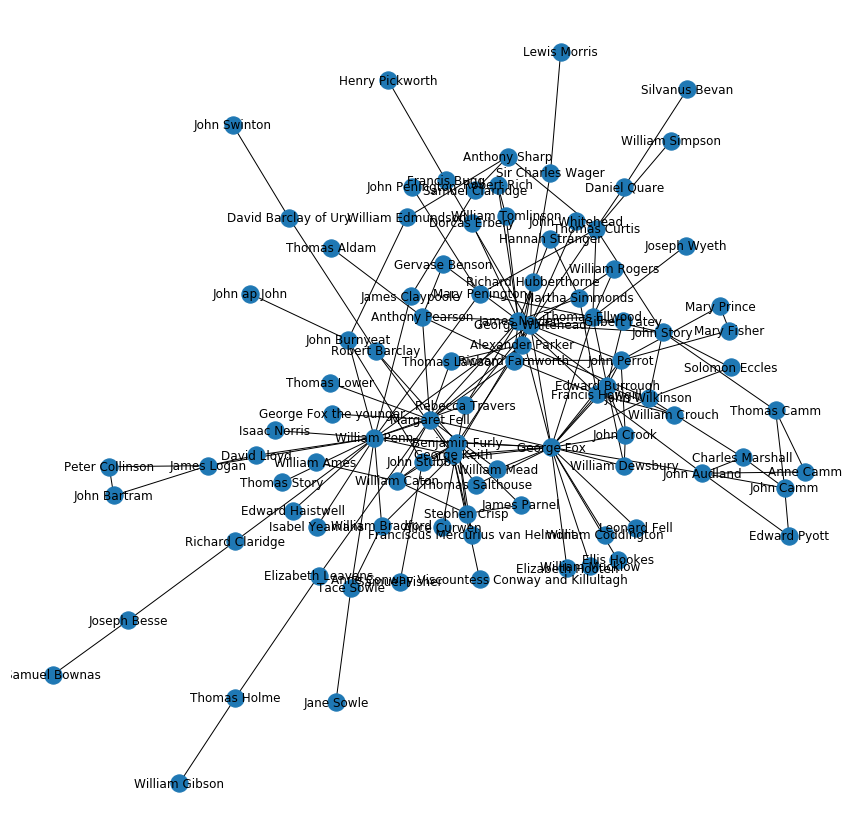

In [34]:
print(nx.info(subgraph))

plt.figure(figsize=(15,15))

sp = nx.spring_layout(subgraph)

plt.axis("off")

nx.draw_networkx(subgraph, pos = sp, with_labels = True)

plt.show()

In our largest component, we have 96 nodes, 162 edges, and an average degree of 3.37.

We discovered that within the largest sub component, the diameter is 8, meaning the shortest path between any pair of nodes in the subnetwork is 8. 

We can also compute triadic closures. Triadic closures can capture instances where if two people know the same person, then they are most likely to know each other. Thus this completes a triangle of associations. In general, triadic closures capture potential triads if two nodes are connected to the same node. 

We also have a measure of triadic closures called Transitivity. Transitivity is the ratio of all triangles over all possible triangles. This measure is also on a 0 to 1 scale. 

In [35]:
triadic_closure = nx.transitivity(G)

print("Triadic closure:", triadic_closure)

Triadic closure: 0.16937799043062202


## Communities 

We have a much better idea of some of the underlying structures within our graph. Up to this point, we examined which nodes had power over the network, which nodes were influential, the size of the largest component, and the ratio of triadic closures. Perhaps we want now examine if nodes could be partitioned into clusters or communities. 

We can actually calculate communities, cliques, and clusters within a network. Lets briefly define what each of these concepts mean: 

communities can find if the network can be grouped into sets of nodes such that each set of node is densely connected internally. Communties can be overlapping and non overlapping. One caveat for non-overlapping communities is that we assume the network can divide naturally into groups of nodes with connections that are dense internally and sparse between groups. 

Cliques are defined as the max complete subgraph of a given graph. A clique is a type of subgraph where every node is directly connected to every other node. No other node can be added to a clique without reducing the connectivity. Cliques are made of overlapping triads.

There is one method that is actually more popular when it comes to detecting communities. This method uses Modularity. Modularity is a measure of relative density in the network. A community in the graph has a high density relative to the other nodes within the community but low density with nodes outside of the community. 

Lets use the greedy_modularity_communities function to compute our modularity metrics. On the backend, this function uses the Clauset-Newman-Moore modularity maximization. At each node within some community, the algorithm joins each node with the pair of communities that increase modularity until there are no more pairs left. The actual math is pretty complex but you can see it here http://ece-research.unm.edu/ifis/papers/community-moore.pdf

In [36]:
from networkx.algorithms.community.centrality import girvan_newman

communities = community.greedy_modularity_communities(G)

In [37]:
modularity_dict = {} # Create a blank dictionary

for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    
    for name in c: # Loop through each person in a community
        
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [45]:
sorted_mod = sorted(modularity_dict.items(), key=itemgetter(1), reverse=True)

#First get the top 20 nodes by modularity class
top_mod = sorted_mod[:50]

#Then find and print their degree
for md in top_mod: # Loop through top_betweenness
    
    degree = degree_dict[md[0]]
    
    print("Name:", md[0], "| Modularity Class:", md[1])

Name: Sarah Gibbons | Modularity Class: 17
Name: Dorothy Waugh | Modularity Class: 17
Name: Mary Pennyman | Modularity Class: 16
Name: Humphrey Woolrich | Modularity Class: 16
Name: Sarah Cheevers | Modularity Class: 15
Name: Katharine Evans | Modularity Class: 15
Name: John Rous | Modularity Class: 14
Name: Humphrey Norton | Modularity Class: 14
Name: Grace Chamber | Modularity Class: 13
Name: Lydia Lancaster | Modularity Class: 13
Name: John Wanton | Modularity Class: 12
Name: Gideon Wanton | Modularity Class: 12
Name: David Barclay | Modularity Class: 11
Name: John Freame | Modularity Class: 11
Name: Richard Vickris | Modularity Class: 10
Name: George Bishop | Modularity Class: 10
Name: John Bellers | Modularity Class: 9
Name: Fettiplace Bellers | Modularity Class: 9
Name: Lilias Skene | Modularity Class: 8
Name: Alexander Skene of Newtyle | Modularity Class: 8
Name: Thomas Taylor | Modularity Class: 7
Name: John Whiting | Modularity Class: 7
Name: Christopher Taylor | Modularity Cl

Using a dictionary, we stored the modularity measure for each node the sameway we stored centrality measures. If we sort their nodes by top modularity, we can see that the highest is 17. This means that we have a total of 17 unique NON OVERLAPPING clusters. By the way, the algorithm used (community.greedy_modularity_communities) is non overlapping. 

Note that the integers for a cluster assignment are not measures. They are just a class labels. 

Lets look at en example of a cluster with modularity measure equal to zero. 

In [42]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0] #Filter by modularity equal to zero

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0} #Isolate eigenvector centrality for modularity zero bodes

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True) #sort

print("Modularity Class 0 Sorted by Eigenvector Centrality:")

for node in class0_sorted_by_eigenvector[:5]:
    
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: William Penn | Eigenvector Centrality: 0.2703220115399868
Name: George Keith | Eigenvector Centrality: 0.18384690867915351
Name: William Bradford | Eigenvector Centrality: 0.06812170326615953
Name: Tace Sowle | Eigenvector Centrality: 0.04688085927497436
Name: James Logan | Eigenvector Centrality: 0.044474460267486554


Lets now look at a print out of all the Non Overlapping cluster assignments that have more than 2 elements (nodes) in them. 

In [13]:
for i,c in enumerate(communities): # Loop through the list of communities
    
    if len(c) > 2: # Filter out modularity clusters with 2 or fewer nodes
        
        print('Class '+str(i)+':', list(c)) # Print out the classes and their members

Class 0: ['David Lloyd', 'John Bartram', 'Richard Claridge', 'Isaac Norris', 'Tace Sowle', 'Edward Haistwell', 'Peter Collinson', 'William Penn', 'William Bradford', 'Isabel Yeamans', 'Anne Conway Viscountess Conway and Killultagh', 'Thomas Story', 'Jane Sowle', 'George Keith', 'Joseph Besse', 'James Logan', 'Samuel Bownas']
Class 1: ['William Tomlinson', 'Anthony Pearson', 'Robert Rich', 'Francis Howgill', 'William Gibson', 'Thomas Holme', 'Gervase Benson', 'Elizabeth Leavens', 'Thomas Aldam', 'Dorcas Erbery', 'James Nayler', 'Margaret Fell', 'Richard Farnworth', 'Martha Simmonds', 'George Fox the younger', 'Thomas Lower', 'Hannah Stranger']
Class 2: ['Ellis Hookes', 'Mary Fisher', 'William Mucklow', 'Mary Prince', 'Leonard Fell', 'William Coddington', 'William Dewsbury', 'John Perrot', 'George Fox', 'John Crook', 'William Crouch', 'William Mead', 'Edward Burrough', 'Thomas Salthouse', 'Elizabeth Hooten']
Class 3: ['Richard Hubberthorne', 'John Whitehead', 'Silvanus Bevan', 'Henry Pic

## Louvin

Louvin community detection is a different greedy algorithm.

Each node is assigned to its own community. For each node i, compute the change in modularity when node i is removed from its own community and placed in a neighbor community.


https://www.eecs.yorku.ca/course_archive/2017-18/F/6412/reading/kdd17p145.pdf
https://hackernoon.com/karate-club-a-python-library-for-graph-representation-learning-05383yh9
https://python-louvain.readthedocs.io/en/latest/

In [69]:
from community import community_louvain


#first compute the best partition
partition = community_louvain.best_partition(G)

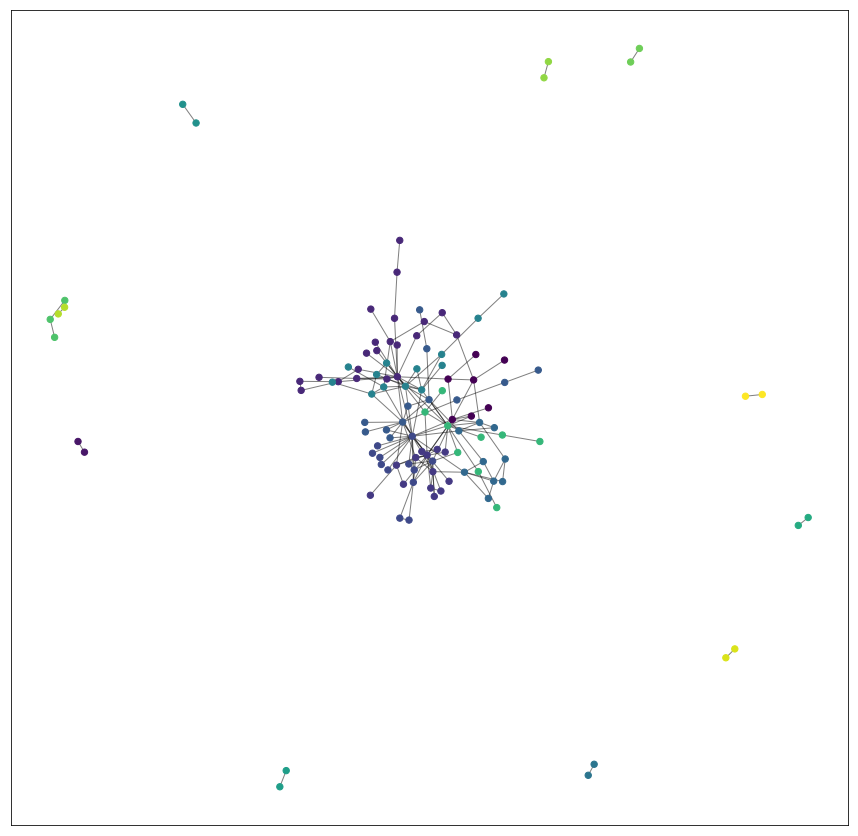

In [70]:
import matplotlib.cm as cm

plt.figure(figsize=(15,15))

# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()), with_labels=True)

nx.draw_networkx_edges(G, pos, alpha=0.5, with_labels=True)

plt.show()

In [71]:
partition

{'Joseph Wyeth': 0,
 'Alexander Skene of Newtyle': 1,
 'James Logan': 2,
 'Dorcas Erbery': 3,
 'Lilias Skene': 1,
 'William Mucklow': 4,
 'Thomas Salthouse': 5,
 'William Dewsbury': 4,
 'John Audland': 6,
 'Richard Claridge': 2,
 'William Bradford': 2,
 'Fettiplace Bellers': 7,
 'John Bellers': 7,
 'Isabel Yeamans': 2,
 'George Fox the younger': 5,
 'George Fox': 4,
 'John Stubbs': 8,
 'Anne Camm': 6,
 'John Camm': 6,
 'Thomas Camm': 6,
 'Katharine Evans': 9,
 'Lydia Lancaster': 10,
 'Samuel Clarridge': 2,
 'Thomas Lower': 5,
 'Gervase Benson': 3,
 'Stephen Crisp': 8,
 'James Claypoole': 2,
 'Thomas Holme': 5,
 'John Freame': 11,
 'John Swinton': 8,
 'William Mead': 5,
 'Henry Pickworth': 12,
 'John Crook': 4,
 'Gilbert Latey': 12,
 'Ellis Hookes': 4,
 'Joseph Besse': 2,
 'James Nayler': 3,
 'Elizabeth Hooten': 4,
 'George Whitehead': 12,
 'John Whitehead': 12,
 'William Crouch': 3,
 'Benjamin Furly': 8,
 'Silvanus Bevan': 12,
 'Robert Rich': 3,
 'John Whiting': 13,
 'Christopher Taylo

## what About Overlapping Clusters?

Community detection is a fairly complex and new area of study. There are several prominent methods to compute overlapping community detection such as Big Clam or Ego Splitting. These methods are complex in that they work best on gigantic networks and are computationally expensive. 

We did not cover overlapping in this section. 


https://www.eecs.yorku.ca/course_archive/2017-18/F/6412/reading/kdd17p145.pdf
https://hackernoon.com/karate-club-a-python-library-for-graph-representation-learning-05383yh9
https://python-louvain.readthedocs.io/en/latest/



## Homework 

Your homework will be to create datasets of interest for the type of workflow shown here: 

You will create a node-attribute table which will contain one unique row per node and attributes pertaining to that node. 

You will create an edge table which will have two columns. Source Node and target node. 

Node: Basic URL otherwise known as slug 

Possible Attributes: Pageviews, topics, unique visitors 

Edges: two URL's are connected if they have a visitor in common. (There could be multiple visitors in common) 
